# Progression
- downloaded all slices from team 2
- annotate manually in QuPath + export as GeoJSONs (avoids the issue of using an epithelium extraction method)
- plotting GeoJSON and saving image as png/jpg
- scan image top to bottom, then left to right (to verify not duplicate epithelium inclusion)
- get longest width and longest height, output which is shorter between the two

## Notes
- Currently using just annotation of epithelium meaning the entire background is white
- once background can reliably be turned black the detection of patches can be formed much easier

## Importing GeoJSONs

In [17]:
#!pip install geopandas matplotlib
#!pip install geojson pandas

In [82]:
import geojson
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the GeoJSON data
with open('D:\\390scans\\h2114155 h&e_ROI_1.geojson') as f:
    data = geojson.load(f)

# Convert to a GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(data['features'])

# Create the plot
fig, ax = plt.subplots()
gdf.plot(ax=ax)

# Invert y-axis to match the original view if needed
plt.gca().invert_yaxis()

# Remove axis labels, ticks, etc.
ax.set_axis_off()

# Save the plot as an image without axis
output_path = 'D:\\390scans\\h2114155.png'
fig.savefig(output_path, bbox_inches='tight', pad_inches=0)

# Close the plot to free up memory
plt.close(fig)

print(f"Plot saved to {output_path}")

Plot saved to D:\390scans\h2114155.png


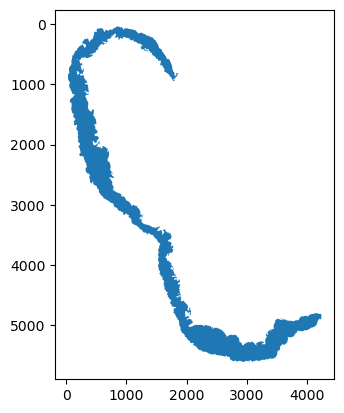

In [83]:
gdf.plot()
plt.gca().invert_yaxis()

# Presentation 5
## Estimate Patch Size

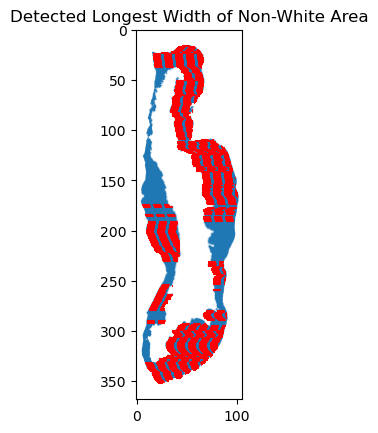

In [63]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the image
image_path = 'D:\\390scans\\h2114153.png'
image = Image.open(image_path)

# Convert the image to a numpy array for analysis
image_np = np.array(image)

# Create a binary mask for any non-white pixel (assuming white is [255, 255, 255])
non_white_mask = (image_np[:, :, 0] < 255) | (image_np[:, :, 1] < 255) | (image_np[:, :, 2] < 255)

# Scan each row to find the longest sequence of non-white pixels and their positions
widths = []
positions = []
for row_idx, row in enumerate(non_white_mask):
    max_width_in_row = 0  # Track the longest sequence in this row
    current_width = 0  # Temporary width counter for the current sequence
    start_pos = None  # Start position of the current sequence
    max_start = max_end = None  # Start and end of the longest sequence

    for col_idx, pixel in enumerate(row):
        if pixel:  # If the pixel is non-white
            if current_width == 0:
                start_pos = col_idx  # Set start position of a new sequence
            current_width += 1  # Increase the width of the current sequence
        else:  # If the pixel is white
            if current_width > max_width_in_row:
                max_width_in_row = current_width
                max_start, max_end = start_pos, col_idx - 1  # Update max sequence positions
            current_width = 0  # Reset current width counter

    # Final check in case the row ends with the longest sequence
    if current_width > max_width_in_row:
        max_width_in_row = current_width
        max_start, max_end = start_pos, len(row) - 1

    # Store the longest sequence width and its start-end positions for this row
    widths.append(max_width_in_row)
    positions.append((max_start, max_end))

# Plot the original image
plt.imshow(image_np)

# Draw dashed lines only over the longest sequence of blue pixels in each row
for row_idx, (width, (start, end)) in enumerate(zip(widths, positions)):
    if width > 0:  # Only draw if there is a non-zero longest sequence
        plt.plot([start, end], [row_idx, row_idx], color='red', linestyle='--')

plt.show()


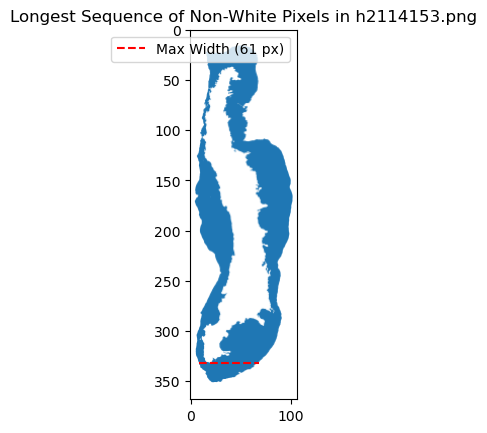

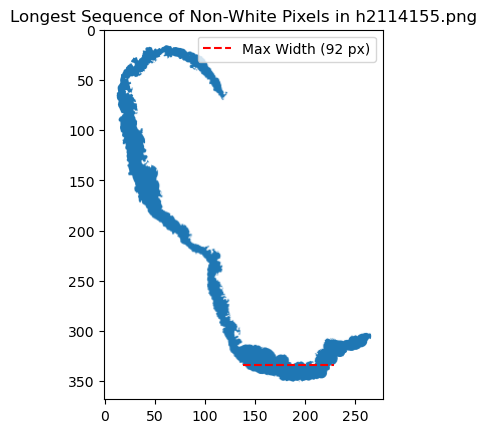

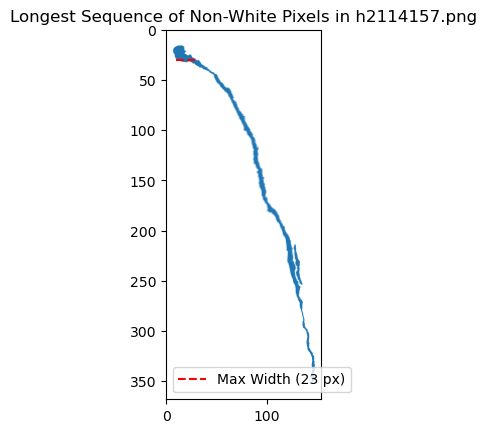

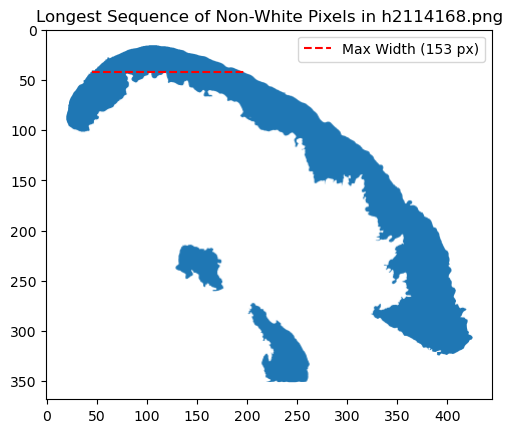

In [97]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def process_image(image_path):
    # Load image
    image = Image.open(image_path)
    image_np = np.array(image)

    # Create a binary mask for any non-white pixel (assuming white is [255, 255, 255])
    non_white_mask = (image_np[:, :, 0] < 255) | (image_np[:, :, 1] < 255) | (image_np[:, :, 2] < 255)

    # Initialize variables for tracking the longest sequence in each row
    max_width = 0
    max_row = None
    max_start = None
    max_end = None

    # Scan each row to find the longest sequence of non-white pixels
    for row_idx, row in enumerate(non_white_mask):
        current_width = 0  # Temporary width counter for the current sequence
        start_pos = None  # Start position of the current sequence

        for col_idx, pixel in enumerate(row):
            if pixel:  # If the pixel is non-white
                if current_width == 0:
                    start_pos = col_idx  # Set start position of a new sequence
                current_width += 1  # Increase the width of the current sequence
            else:  # If the pixel is white
                if current_width > max_width:
                    max_width = current_width
                    max_row = row_idx
                    max_start = start_pos
                    max_end = col_idx - 1  # Update max sequence positions
                current_width = 0  # Reset current width counter

        # Final check in case the row ends with the longest sequence
        if current_width > max_width:
            max_width = current_width
            max_row = row_idx
            max_start = start_pos
            max_end = len(row) - 1

    # Plot the result for the current image
    plt.figure()
    plt.imshow(image_np)
    if max_width > 0:
        # Draw a dashed line over the longest sequence of non-white pixels in the row with max width
        plt.plot([max_start, max_end], [max_row, max_row], color='red', linestyle='--', label=f'Max Width ({max_width} px)')
        plt.legend()
    plt.title(f'Longest Sequence of Non-White Pixels in {os.path.basename(image_path)}')
    plt.show()

def process_folder(folder_path):
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for image files
            image_path = os.path.join(folder_path, filename)
            process_image(image_path)  # Process and plot each image

# Specify the folder path containing images
folder_path = 'D:\\390scans\\extractions'

# Run the function on the folder
process_folder(folder_path)


### above code widest width would not see stroma, made adjustmens by adding a valid boolean
- note: for scan h2114157, this new condition would result in no valid width since epithelium will not appear on both sides. It will then not validate any widths for this scan with the below changes. For tissues like this using the above code is ok.

     Pixel Height  Longest Width of Non-White Area  Is Valid
0               0                                0     False
1               1                                0     False
2               2                                0     False
3               3                                0     False
4               4                                0     False
..            ...                              ...       ...
364           364                                0     False
365           365                                0     False
366           366                                0     False
367           367                                0     False
368           368                                0     False

[369 rows x 3 columns]


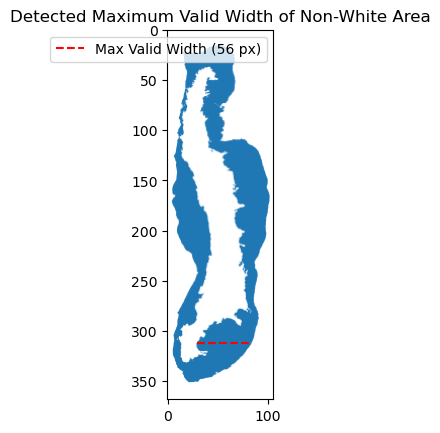

In [96]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the new uploaded image
image_path = 'D:\\390scans\\h2114153.png'
image = Image.open(image_path)

# Convert the image to a numpy array for analysis
image_np = np.array(image)

# Create a binary mask for any non-white pixel (assuming white is [255, 255, 255])
non_white_mask = (image_np[:, :, 0] < 255) | (image_np[:, :, 1] < 255) | (image_np[:, :, 2] < 255)

# Initialize variables to track the longest sequence in each row
widths = []
validity = []

# Scan each row to find the longest sequence of non-white pixels
for row_idx, row in enumerate(non_white_mask):
    max_width_in_row = 0  # Track the longest sequence in this row
    current_width = 0  # Temporary width counter for the current sequence
    start_pos = None  # Start position of the current sequence

    # Detect the first and last non-white pixels in the row
    first_non_white = np.argmax(row) if np.any(row) else None
    last_non_white = len(row) - np.argmax(row[::-1]) - 1 if np.any(row) else None

    for col_idx, pixel in enumerate(row):
        if pixel:  # If the pixel is non-white
            if current_width == 0:
                start_pos = col_idx  # Set start position of a new sequence
            current_width += 1  # Increase the width of the current sequence
        else:  # If the pixel is white
            if current_width > max_width_in_row:
                max_width_in_row = current_width
            current_width = 0  # Reset current width counter

    # Final check in case the row ends with the longest sequence
    if current_width > max_width_in_row:
        max_width_in_row = current_width

    # Only proceed with the validity check if start_pos and max_width_in_row are defined
    if start_pos is not None and max_width_in_row > 0:
        # Ensure that there are at least 10 consecutive white pixels before and after the blue segment
        # this is to ensure small noisey elements on the side of epithelium do not affect width calculation
        has_white_buffer = (
            start_pos >= 10 and  # Ensure there's enough room on the left for 10 pixels
            all(not row[start_pos - i - 1] for i in range(10)) and  # 10 white pixels before
            (start_pos + max_width_in_row + 10 <= len(row)) and  # Ensure enough room on the right
            all(not row[start_pos + max_width_in_row + i] for i in range(10))  # 10 white pixels after
        )
        
        # Check if the sequence does not touch the left and right boundaries
        is_valid = (
            first_non_white is not None and last_non_white is not None and 
            not (start_pos == first_non_white and (start_pos + max_width_in_row - 1) == last_non_white) and
            has_white_buffer
        )
    else:
        is_valid = False

    # Store the longest sequence width and its validity for this row
    widths.append(max_width_in_row)
    validity.append(is_valid)

# Convert results to a DataFrame for easy viewing
width_df = pd.DataFrame({
    'Pixel Height': range(len(widths)),
    'Longest Width of Non-White Area': widths,
    'Is Valid': validity
})

# Display the DataFrame
print(width_df)

# Identify the maximum valid width across all rows
valid_rows = width_df[width_df['Is Valid']]
if not valid_rows.empty:
    max_valid_width_row = valid_rows['Longest Width of Non-White Area'].idxmax()
    max_valid_width = valid_rows.loc[max_valid_width_row, 'Longest Width of Non-White Area']
    max_row = valid_rows.loc[max_valid_width_row, 'Pixel Height']

    # Get the start and end positions for plotting purposes
    row = non_white_mask[max_row]
    current_width = 0
    start = None
    for col_idx, pixel in enumerate(row):
        if pixel:
            if current_width == 0:
                start = col_idx
            current_width += 1
            if current_width == max_valid_width:
                end = col_idx
                break
        else:
            current_width = 0

    # Plot the original image
    plt.imshow(image_np)

    # Draw a dashed line only over the longest valid sequence of non-white pixels in the row with max width
    plt.plot([start, end], [max_row, max_row], color='red', linestyle='--', label=f'Max Valid Width ({max_valid_width} px)')
    plt.legend()
else:
    print("No valid widths found.")

plt.title("Detected Maximum Valid Width of Non-White Area")
plt.show()

## scanning for height as well in case there is a shorter length vs. width

     Pixel Width  Longest Height of Non-White Area  Is Valid
0              0                                 0     False
1              1                                 0     False
2              2                                 0     False
3              3                                 0     False
4              4                                 2     False
..           ...                               ...       ...
101          101                                11     False
102          102                                 0     False
103          103                                 0     False
104          104                                 0     False
105          105                                 0     False

[106 rows x 3 columns]


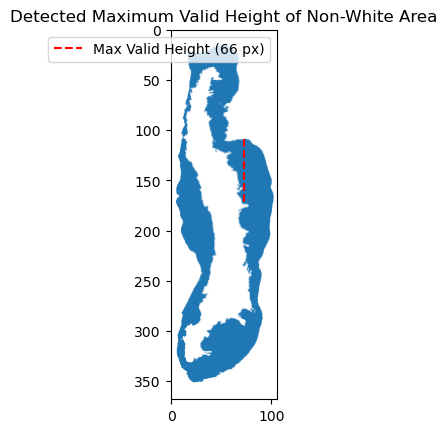

In [93]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the new uploaded image
image_path = 'D:\\390scans\\h2114153.png'
image = Image.open(image_path)

# Convert the image to a numpy array for analysis
image_np = np.array(image)

# Create a binary mask for any non-white pixel (assuming white is [255, 255, 255])
non_white_mask = (image_np[:, :, 0] < 255) | (image_np[:, :, 1] < 255) | (image_np[:, :, 2] < 255)

# Transpose the mask so we can scan columns as if they were rows
non_white_mask_T = non_white_mask.T  # Transpose the array to work with columns as rows

# Initialize variables to track the longest sequence in each column
heights = []
validity = []

# Scan each "column" (now a row in transposed array) to find the longest sequence of non-white pixels
for col_idx, col in enumerate(non_white_mask_T):
    max_height_in_col = 0  # Track the longest sequence in this column
    current_height = 0  # Temporary height counter for the current sequence
    start_pos = None  # Start position of the current sequence

    # Detect the first and last non-white pixels in the column
    first_non_white = np.argmax(col) if np.any(col) else None
    last_non_white = len(col) - np.argmax(col[::-1]) - 1 if np.any(col) else None

    for row_idx, pixel in enumerate(col):
        if pixel:  # If the pixel is non-white
            if current_height == 0:
                start_pos = row_idx  # Set start position of a new sequence
            current_height += 1  # Increase the height of the current sequence
        else:  # If the pixel is white
            if current_height > max_height_in_col:
                max_height_in_col = current_height
            current_height = 0  # Reset current height counter

    # Final check in case the column ends with the longest sequence
    if current_height > max_height_in_col:
        max_height_in_col = current_height

    # Only proceed with the validity check if start_pos and max_height_in_col are defined
    if start_pos is not None and max_height_in_col > 0:
        # Ensure that there are at least 10 consecutive white pixels above and below the blue segment
        has_white_buffer = (
            start_pos >= 10 and  # Ensure there's enough room at the top for 10 pixels
            all(not col[start_pos - i - 1] for i in range(10)) and  # 10 white pixels above
            (start_pos + max_height_in_col + 10 <= len(col)) and  # Ensure enough room at the bottom
            all(not col[start_pos + max_height_in_col + i] for i in range(10))  # 10 white pixels below
        )
        
        # Check if the sequence does not touch the top and bottom boundary
        is_valid = (
            first_non_white is not None and last_non_white is not None and 
            not (start_pos == first_non_white and (start_pos + max_height_in_col - 1) == last_non_white) and
            has_white_buffer
        )
    else:
        is_valid = False

    # Store the longest sequence height and its validity for this column
    heights.append(max_height_in_col)
    validity.append(is_valid)

# Convert results to a DataFrame for easy viewing
height_df = pd.DataFrame({
    'Pixel Width': range(len(heights)),
    'Longest Height of Non-White Area': heights,
    'Is Valid': validity
})

# Display the DataFrame
print(height_df)

# Identify the maximum valid height across all columns
valid_cols = height_df[height_df['Is Valid']]
if not valid_cols.empty:
    max_valid_height_col = valid_cols['Longest Height of Non-White Area'].idxmax()
    max_valid_height = valid_cols.loc[max_valid_height_col, 'Longest Height of Non-White Area']
    max_col = valid_cols.loc[max_valid_height_col, 'Pixel Width']

    # Get the start and end positions for plotting purposes
    col = non_white_mask_T[max_col]
    current_height = 0
    start = None
    for row_idx, pixel in enumerate(col):
        if pixel:
            if current_height == 0:
                start = row_idx
            current_height += 1
            if current_height == max_valid_height:
                end = row_idx
                break
        else:
            current_height = 0

    # Plot the original image
    plt.imshow(image_np)

    # Draw a dashed line only over the longest valid sequence of non-white pixels in the column with max height
    plt.plot([max_col, max_col], [start, end], color='red', linestyle='--', label=f'Max Valid Height ({max_valid_height} px)')
    plt.legend()
else:
    print("No valid heights found.")

plt.title("Detected Maximum Valid Height of Non-White Area")
plt.show()

# combine height and width to output the minimum of the two max lengths

In [94]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the new uploaded image
image_path = 'D:\\390scans\\h2114153.png'
image = Image.open(image_path)

# Convert the image to a numpy array for analysis
image_np = np.array(image)

# Create a binary mask for any non-white pixel (assuming white is [255, 255, 255])
non_white_mask = (image_np[:, :, 0] < 255) | (image_np[:, :, 1] < 255) | (image_np[:, :, 2] < 255)

# Initialize variables for tracking max width and max height
widths = []
height_validity = []
validity = []
heights = []

# Compute maximum valid width in each row
for row_idx, row in enumerate(non_white_mask):
    max_width_in_row = 0
    current_width = 0
    start_pos = None

    first_non_white = np.argmax(row) if np.any(row) else None
    last_non_white = len(row) - np.argmax(row[::-1]) - 1 if np.any(row) else None

    for col_idx, pixel in enumerate(row):
        if pixel:
            if current_width == 0:
                start_pos = col_idx
            current_width += 1
        else:
            if current_width > max_width_in_row:
                max_width_in_row = current_width
            current_width = 0

    if current_width > max_width_in_row:
        max_width_in_row = current_width

    if start_pos is not None and max_width_in_row > 0:
        has_white_buffer = (
            start_pos >= 10 and
            all(not row[start_pos - i - 1] for i in range(10)) and
            (start_pos + max_width_in_row + 10 <= len(row)) and
            all(not row[start_pos + max_width_in_row + i] for i in range(10))
        )
        is_valid = (
            first_non_white is not None and last_non_white is not None and 
            not (start_pos == first_non_white and (start_pos + max_width_in_row - 1) == last_non_white) and
            has_white_buffer
        )
    else:
        is_valid = False

    widths.append(max_width_in_row)
    validity.append(is_valid)

# Find the maximum valid width
width_df = pd.DataFrame({
    'Pixel Height': range(len(widths)),
    'Longest Width of Non-White Area': widths,
    'Is Valid': validity
})

valid_rows = width_df[width_df['Is Valid']]
if not valid_rows.empty:
    max_valid_width_row = valid_rows['Longest Width of Non-White Area'].idxmax()
    max_valid_width = valid_rows.loc[max_valid_width_row, 'Longest Width of Non-White Area']
else:
    max_valid_width = 0

# Compute maximum valid height in each column
non_white_mask_T = non_white_mask.T

for col_idx, col in enumerate(non_white_mask_T):
    max_height_in_col = 0
    current_height = 0
    start_pos = None

    first_non_white = np.argmax(col) if np.any(col) else None
    last_non_white = len(col) - np.argmax(col[::-1]) - 1 if np.any(col) else None

    for row_idx, pixel in enumerate(col):
        if pixel:
            if current_height == 0:
                start_pos = row_idx
            current_height += 1
        else:
            if current_height > max_height_in_col:
                max_height_in_col = current_height
            current_height = 0

    if current_height > max_height_in_col:
        max_height_in_col = current_height

    if start_pos is not None and max_height_in_col > 0:
        has_white_buffer = (
            start_pos >= 10 and
            all(not col[start_pos - i - 1] for i in range(10)) and
            (start_pos + max_height_in_col + 10 <= len(col)) and
            all(not col[start_pos + max_height_in_col + i] for i in range(10))
        )
        is_valid = (
            first_non_white is not None and last_non_white is not None and 
            not (start_pos == first_non_white and (start_pos + max_height_in_col - 1) == last_non_white) and
            has_white_buffer
        )
    else:
        is_valid = False

    heights.append(max_height_in_col)
    height_validity.append(is_valid)

# Find the maximum valid height
height_df = pd.DataFrame({
    'Pixel Width': range(len(heights)),
    'Longest Height of Non-White Area': heights,
    'Is Valid': height_validity
})

valid_cols = height_df[height_df['Is Valid']]
if not valid_cols.empty:
    max_valid_height_col = valid_cols['Longest Height of Non-White Area'].idxmax()
    max_valid_height = valid_cols.loc[max_valid_height_col, 'Longest Height of Non-White Area']
else:
    max_valid_height = 0

# Determine which one to use (whichever is shorter)
if max_valid_height < max_valid_width:
    preferred_measurement = "Height"
    preferred_value = max_valid_height
else:
    preferred_measurement = "Width"
    preferred_value = max_valid_width

# Output the result
print(f"The preferred measurement is: {preferred_measurement}")
print(f"The length of the preferred measurement is: {preferred_value} px")


The preferred measurement is: Width
The length of the preferred measurement is: 56 px


## automating with folder of images

In [84]:
import os
from PIL import Image
import numpy as np
import pandas as pd

def process_image(image_path):
    # Load image
    image = Image.open(image_path)
    image_np = np.array(image)

    # Create a binary mask for any non-white pixel (assuming white is [255, 255, 255])
    non_white_mask = (image_np[:, :, 0] < 255) | (image_np[:, :, 1] < 255) | (image_np[:, :, 2] < 255)

    # Initialize variables for tracking max width and max height
    widths = []
    validity = []
    heights = []
    height_validity = []

    # Compute maximum valid width in each row
    for row_idx, row in enumerate(non_white_mask):
        max_width_in_row = 0
        current_width = 0
        start_pos = None

        first_non_white = np.argmax(row) if np.any(row) else None
        last_non_white = len(row) - np.argmax(row[::-1]) - 1 if np.any(row) else None

        for col_idx, pixel in enumerate(row):
            if pixel:
                if current_width == 0:
                    start_pos = col_idx
                current_width += 1
            else:
                if current_width > max_width_in_row:
                    max_width_in_row = current_width
                current_width = 0

        if current_width > max_width_in_row:
            max_width_in_row = current_width

        if start_pos is not None and max_width_in_row > 0:
            has_white_buffer = (
                start_pos >= 10 and
                all(not row[start_pos - i - 1] for i in range(10)) and
                (start_pos + max_width_in_row + 10 <= len(row)) and
                all(not row[start_pos + max_width_in_row + i] for i in range(10))
            )
            is_valid = (
                first_non_white is not None and last_non_white is not None and 
                not (start_pos == first_non_white and (start_pos + max_width_in_row - 1) == last_non_white) and
                has_white_buffer
            )
        else:
            is_valid = False

        widths.append(max_width_in_row)
        validity.append(is_valid)

    # Find the maximum valid width
    width_df = pd.DataFrame({
        'Pixel Height': range(len(widths)),
        'Longest Width of Non-White Area': widths,
        'Is Valid': validity
    })

    valid_rows = width_df[width_df['Is Valid']]
    if not valid_rows.empty:
        max_valid_width = valid_rows['Longest Width of Non-White Area'].max()
    else:
        max_valid_width = 0

    # Compute maximum valid height in each column
    non_white_mask_T = non_white_mask.T

    for col_idx, col in enumerate(non_white_mask_T):
        max_height_in_col = 0
        current_height = 0
        start_pos = None

        first_non_white = np.argmax(col) if np.any(col) else None
        last_non_white = len(col) - np.argmax(col[::-1]) - 1 if np.any(col) else None

        for row_idx, pixel in enumerate(col):
            if pixel:
                if current_height == 0:
                    start_pos = row_idx
                current_height += 1
            else:
                if current_height > max_height_in_col:
                    max_height_in_col = current_height
                current_height = 0

        if current_height > max_height_in_col:
            max_height_in_col = current_height

        if start_pos is not None and max_height_in_col > 0:
            has_white_buffer = (
                start_pos >= 10 and
                all(not col[start_pos - i - 1] for i in range(10)) and
                (start_pos + max_height_in_col + 10 <= len(col)) and
                all(not col[start_pos + max_height_in_col + i] for i in range(10))
            )
            is_valid = (
                first_non_white is not None and last_non_white is not None and 
                not (start_pos == first_non_white and (start_pos + max_height_in_col - 1) == last_non_white) and
                has_white_buffer
            )
        else:
            is_valid = False

        heights.append(max_height_in_col)
        height_validity.append(is_valid)

    # Find the maximum valid height
    height_df = pd.DataFrame({
        'Pixel Width': range(len(heights)),
        'Longest Height of Non-White Area': heights,
        'Is Valid': height_validity
    })

    valid_cols = height_df[height_df['Is Valid']]
    if not valid_cols.empty:
        max_valid_height = valid_cols['Longest Height of Non-White Area'].max()
    else:
        max_valid_height = 0

    # Determine the preferred measurement (shorter one)
    if max_valid_height < max_valid_width:
        preferred_measurement = "Height"
        preferred_value = max_valid_height
    else:
        preferred_measurement = "Width"
        preferred_value = max_valid_width

    return preferred_measurement, preferred_value

# Main function to process all images in a folder
def process_folder(folder_path):
    results = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):
            image_path = os.path.join(folder_path, filename)
            preferred_measurement, preferred_value = process_image(image_path)
            results.append({
                'Image Name': filename,
                'Preferred Measurement': preferred_measurement,
                'Pixels': preferred_value
            })

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Specify folder path
folder_path = 'D:\\390scans\\extractions'

# Process folder and display results
results_df = process_folder(folder_path)
results_df


,Image Name,Preferred Measurement,Pixels
0,h2114153.png,Width,56
1,h2114155.png,Width,54
2,h2114157.png,Width,0
3,h2114168.png,Height,76


## black background - simulated
- done via MS paint

The preferred measurement is: Width
The length of the preferred measurement is: 54 px


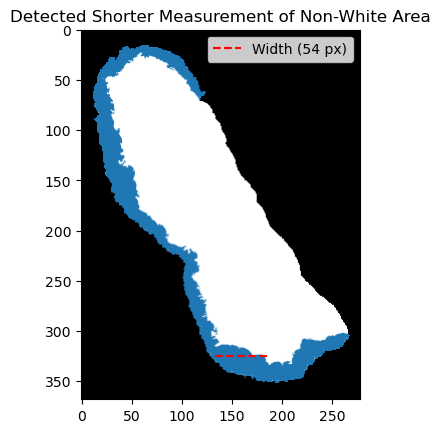

In [76]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the new uploaded image
image_path = 'D:\\390scans\\h2114155_black.png'
image = Image.open(image_path)

# Convert the image to a numpy array for analysis
image_np = np.array(image)

# Define binary masks for exact black, white, and blue pixels
black_mask = (image_np[:, :, 0] == 0) & (image_np[:, :, 1] == 0) & (image_np[:, :, 2] == 0)
white_mask = (image_np[:, :, 0] == 255) & (image_np[:, :, 1] == 255) & (image_np[:, :, 2] == 255)
blue_mask = ~black_mask & ~white_mask  # Any pixel that is neither black nor white

# Initialize variables for tracking max width and max height
widths = []
validity = []
heights = []
height_validity = []

# Compute maximum valid width in each row
for row_idx, row in enumerate(blue_mask):
    max_width_in_row = 0
    current_width = 0
    start_pos = None

    for col_idx, pixel in enumerate(row):
        if pixel:
            if current_width == 0:
                start_pos = col_idx
            current_width += 1
        else:
            if current_width > 0:
                has_black_white_buffer = (
                    start_pos >= 5 and
                    all(black_mask[row_idx, start_pos - i - 1] for i in range(5)) and
                    (start_pos + current_width + 5 <= len(row)) and
                    all(white_mask[row_idx, start_pos + current_width + i] for i in range(5))
                )
                has_white_black_buffer = (
                    start_pos >= 5 and
                    all(white_mask[row_idx, start_pos - i - 1] for i in range(5)) and
                    (start_pos + current_width + 5 <= len(row)) and
                    all(black_mask[row_idx, start_pos + current_width + i] for i in range(5))
                )
                
                is_valid = has_black_white_buffer or has_white_black_buffer
                if is_valid and current_width > max_width_in_row:
                    max_width_in_row = current_width
                    max_width_start = start_pos  # Track start position of max width in this row

            current_width = 0

    if current_width > 0:
        has_black_white_buffer = (
            start_pos >= 5 and
            all(black_mask[row_idx, start_pos - i - 1] for i in range(5)) and
            (start_pos + current_width + 5 <= len(row)) and
            all(white_mask[row_idx, start_pos + current_width + i] for i in range(5))
        )
        has_white_black_buffer = (
            start_pos >= 5 and
            all(white_mask[row_idx, start_pos - i - 1] for i in range(5)) and
            (start_pos + current_width + 5 <= len(row)) and
            all(black_mask[row_idx, start_pos + current_width + i] for i in range(5))
        )

        is_valid = has_black_white_buffer or has_white_black_buffer
        if is_valid and current_width > max_width_in_row:
            max_width_in_row = current_width
            max_width_start = start_pos

    widths.append(max_width_in_row)
    validity.append(is_valid)

width_df = pd.DataFrame({
    'Pixel Height': range(len(widths)),
    'Longest Width of Non-White Area': widths,
    'Is Valid': validity
})
valid_rows = width_df[width_df['Is Valid']]
if not valid_rows.empty:
    max_valid_width_row = valid_rows['Longest Width of Non-White Area'].idxmax()
    max_valid_width = valid_rows.loc[max_valid_width_row, 'Longest Width of Non-White Area']
    max_row = valid_rows.loc[max_valid_width_row, 'Pixel Height']
else:
    max_valid_width = 0
    max_row = None

# Compute maximum valid height in each column
for col_idx, col in enumerate(blue_mask.T):
    max_height_in_col = 0
    current_height = 0
    start_pos = None

    for row_idx, pixel in enumerate(col):
        if pixel:
            if current_height == 0:
                start_pos = row_idx
            current_height += 1
        else:
            if current_height > 0:
                has_black_white_buffer = (
                    start_pos >= 5 and
                    all(black_mask[start_pos - i - 1, col_idx] for i in range(5)) and
                    (start_pos + current_height + 5 <= len(col)) and
                    all(white_mask[start_pos + current_height + i, col_idx] for i in range(5))
                )
                has_white_black_buffer = (
                    start_pos >= 5 and
                    all(white_mask[start_pos - i - 1, col_idx] for i in range(5)) and
                    (start_pos + current_height + 5 <= len(col)) and
                    all(black_mask[start_pos + current_height + i, col_idx] for i in range(5))
                )

                is_valid = has_black_white_buffer or has_white_black_buffer
                if is_valid and current_height > max_height_in_col:
                    max_height_in_col = current_height
                    max_height_start = start_pos

            current_height = 0

    if current_height > 0:
        has_black_white_buffer = (
            start_pos >= 5 and
            all(black_mask[start_pos - i - 1, col_idx] for i in range(5)) and
            (start_pos + current_height + 5 <= len(col)) and
            all(white_mask[start_pos + current_height + i, col_idx] for i in range(5))
        )
        has_white_black_buffer = (
            start_pos >= 5 and
            all(white_mask[start_pos - i - 1, col_idx] for i in range(5)) and
            (start_pos + current_height + 5 <= len(col)) and
            all(black_mask[start_pos + current_height + i, col_idx] for i in range(5))
        )

        is_valid = has_black_white_buffer or has_white_black_buffer
        if is_valid and current_height > max_height_in_col:
            max_height_in_col = current_height
            max_height_start = start_pos

    heights.append(max_height_in_col)
    height_validity.append(is_valid)

height_df = pd.DataFrame({
    'Pixel Width': range(len(heights)),
    'Longest Height of Non-White Area': heights,
    'Is Valid': height_validity
})
valid_cols = height_df[height_df['Is Valid']]
if not valid_cols.empty:
    max_valid_height_col = valid_cols['Longest Height of Non-White Area'].idxmax()
    max_valid_height = valid_cols.loc[max_valid_height_col, 'Longest Height of Non-White Area']
    max_col = valid_cols.loc[max_valid_height_col, 'Pixel Width']
else:
    max_valid_height = 0
    max_col = None

# Determine preferred measurement
if max_valid_height < max_valid_width:
    preferred_measurement = "Height"
    preferred_value = max_valid_height
    plot_line = ([max_col, max_col], [max_height_start, max_height_start + max_valid_height])
else:
    preferred_measurement = "Width"
    preferred_value = max_valid_width
    plot_line = ([max_width_start, max_width_start + max_valid_width], [max_row, max_row])

# Output result
print(f"The preferred measurement is: {preferred_measurement}")
print(f"The length of the preferred measurement is: {preferred_value} px")

# Plot with preferred measurement
plt.imshow(image_np)
plt.plot(*plot_line, color='red', linestyle='--', label=f'{preferred_measurement} ({preferred_value} px)')
plt.legend()
plt.title("Detected Shorter Measurement of Non-White Area")
plt.show()